In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

# Data and setup

In [63]:
# Loads base map
basemap = plt.colormaps["tab10"]
NUMBER_BASE = basemap.N

data = [[228, 820, 163, 17], [18, 78, 17, 0], [97, 613, 165, 12], [1, 42, 8, 0], [56, 829, 755, 23]]
labels = [['R1-6','R7','R8','R9','R10'],['Fellows', 'Members', 'Students', 'Affiliates']]
data = [[[1,3],[1,1]],[[4,5],[1,1]]]
labels = [['L11','L12'],['L21','L22'],['L31','L32']]

In [64]:
data_array = np.array(data)
NUMBER_ITEMS_PER_LEVEL = np.array(np.shape(data_array))
NUMBER_LEVELS = NUMBER_ITEMS_PER_LEVEL.size

# Creation of colormap
The colormap allows one to create colors that decrease in intensity at each level. To keep a unity of color, a given base color is split into subcolors with different alphas. 

The colormap cycles over `NUMBER_BASE` colors (max is 10 because it's inherited from tab10)
- There are `NUMBER_LEVELS` levels to plot
- The number of items is specified in a list `NUMBER_ITEMS_PER_LEVEL`

*Warning:* the data has to be balanced

Assume there are $L$ levels, each with $n_\ell$ items ($\ell\in[0;L-1]$)

The color map is indexed in such a way that:
- The first level colors are with indices $i$ for $i\in[0;n_{0}-1]$
- The second level colors are with indices $n_0+j $ for $j\in[0;n_{1}-1]$
- The third level colors are with indices $n_0+n_1\times n_0+ k$ for $k\in[0;n_{2}-1]$
- More generally, the $t$th level colors are indexed by $\sum_{\ell=0}^{t-1}\prod_{k=0}^{\ell}n_k + s$ for $s\in[0;n_{t}-1]$

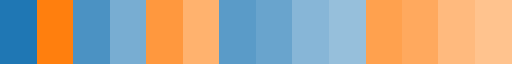

In [65]:
# Creates base colors
my_map = []
for i in np.arange(NUMBER_ITEMS_PER_LEVEL[0]):
    my_map.append(list(basemap(np.mod(i,NUMBER_BASE))))


# print(alpha_range)

alpha_per_level = [[1]]
alpha_range = [[1.0,0.4]]
low_alpha_range = alpha_range[0][1]

for level in np.arange(1,NUMBER_LEVELS):
    nb_items = NUMBER_ITEMS_PER_LEVEL[level]
    # print("Level: " +str(level))
    level_alpha = []
    for i in np.arange(0,len(alpha_range[level-1])):
        # print("Current alpha " + str(alpha_range[level-1][i]))
        if alpha_range[level-1][i] >low_alpha_range:
            # print("Start " + str(alpha_range[level-1][i]))
            delta = (alpha_range[level-1][i]-alpha_range[level-1][i+1])/(nb_items+1)
            # print("Delta " + str(delta))
            new_alphas = list(alpha_range[level-1][i] - delta*np.arange(1,nb_items+2))
            # print(new_alphas)
            alpha_range.append(new_alphas)
            for new_alpha in new_alphas[0:-1]:
                level_alpha.append(new_alpha)
    alpha_per_level.append(level_alpha)
# print(alpha_per_level)
# print(alpha_range)

my_level_map = []
NUMBER_CUM_ITEMS_PER_LEVEL = np.cumprod(NUMBER_ITEMS_PER_LEVEL)/NUMBER_ITEMS_PER_LEVEL[0]
# print(NUMBER_CUM_ITEMS_PER_LEVEL)
for level in np.arange(NUMBER_LEVELS):
    for base_color in my_map: 
        if level==0:
            my_level_map.append(base_color)
        else:
            for item in np.arange(int(NUMBER_CUM_ITEMS_PER_LEVEL[level])):
                # print(level,item)
                new_color = base_color[0:3]
                alpha = alpha_per_level[level][item]
                new_color.append(alpha)
                my_level_map.append(new_color)

matplotlib.colors.ListedColormap(my_level_map)

# Creation of onion rings

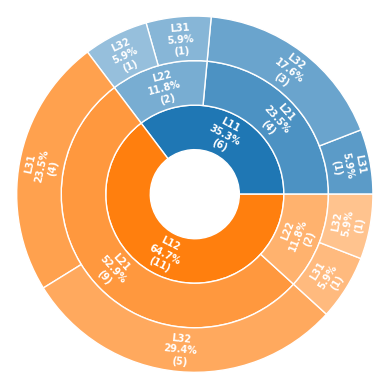

In [67]:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
SIZE = 1/(NUMBER_LEVELS+1)
PLOT_THRESHOLD = 0.015

# Normalize data_array values to 2 pi
values_normalized = data_array/np.sum(data_array)
values_in_angles = values_normalized*2*np.pi

# Computes boundaries of different levels
width_values_at_level = []
original_values_at_level = []
percent_values_at_level = []
edge_values_at_level = []
for level in np.arange(NUMBER_LEVELS-1,-1,-1):
    if level == NUMBER_LEVELS-1:
        hierachical_values_in_angle = values_in_angles
        hierarchical_original_values = data_array
        hierarchical_percent_values = values_normalized
    else:
        hierachical_values_in_angle = hierachical_values_in_angle.sum(axis=level+1)
        hierarchical_original_values = hierarchical_original_values.sum(axis=level+1)
        hierarchical_percent_values = hierarchical_percent_values.sum(axis=level+1)
    edge_values_at_level.insert(0,np.cumsum(np.append(0, hierachical_values_in_angle.flatten()[:-1])))
    width_values_at_level.insert(0,hierachical_values_in_angle.flatten())
    original_values_at_level.insert(0,hierarchical_original_values.flatten())
    percent_values_at_level.insert(0,hierarchical_percent_values.flatten())

# Plots layers of the onion
for level in np.arange(NUMBER_LEVELS):
    # Extracts the colormap for the level
    if level ==0 :
        start_color_index = 0
        stop_color_index = start_color_index + NUMBER_ITEMS_PER_LEVEL[level]
    else:
        start_color_index = stop_color_index
        stop_color_index  = start_color_index + np.prod(np.array(NUMBER_ITEMS_PER_LEVEL)[0:level+1])
    colors_level = my_level_map[start_color_index:stop_color_index]
    # Plots the layer
    ax.bar(x=edge_values_at_level[level], 
            width=width_values_at_level[level], 
            bottom=2*SIZE+level*2*SIZE, 
            height=2*SIZE, 
            color=colors_level, 
            edgecolor='w', 
            linewidth=1, 
            align="edge") # , label=labels[level]

    # Prints labels
    region_edges = edge_values_at_level[level]
    for i in np.arange(len(region_edges)):
        if i< len(region_edges)-1:
            angle = (region_edges[i]+region_edges[i+1])*0.5  
        else:
            angle = (region_edges[len(region_edges)-1]+2*np.pi)*0.5
        if angle>np.pi:
            text_rotation=0
        else:
            text_rotation = angle+180
        if percent_values_at_level[level][i]>PLOT_THRESHOLD:
            current_label = labels[level][np.mod(i,NUMBER_ITEMS_PER_LEVEL[level])] + "\n"+str(np.round(percent_values_at_level[level][i]*100,1))+"%\n({})".format(original_values_at_level[level][i])
            plt.text(angle,3*SIZE+level*2*SIZE,current_label,size=7,ha='center',va='center',color='white',weight='bold',rotation=text_rotation, rotation_mode='anchor',transform_rotates_text=True)

ax.set_axis_off()